# Modified from Chapter 7 Tutorial a First Course on Network Science Book

This tutorial will show you how to use the included Simulation class to simulate node dynamics by specifying a graph, the initial state of the nodes, and node state transitions. 
If the libraries can't be locally installed, run it in data hubs
link to the source: https://github.com/CambridgeUniversityPress/FirstCourseNetworkScience/blob/master/tutorials/Chapter%207%20Tutorial.ipynb 

Contents:

1. The Simulation class
2. Voter model
3. SIS model
4. Conclusion

# 1. The Simulation class

Here I am adding the content of `simulation.py` file that contains a `Simulation` class. This class will allow us to skip the details of writing a simulation, allowing us to concentrate on the interesting parts.

## 1.1 Creating a simulation

A simulation is made up of three main parts:

1. The graph on which to simulate node dynamics
2. The initial state of each node
3. The state transition function

### 1.1.1 The graph

This one is easy, we just need a NetworkX Graph instance. For this example we'll use a random graph. You can run the following cell multiple times if you wish, until you get a graph that looks good:

In [1]:
'''
Simulation class for Chapter 7 Tutorial of Intro Network Science book

Copyright 2018 Indiana University and Cambridge University Press
'''

from collections import Counter
from operator import itemgetter

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx


class StopCondition(StopIteration):
    pass

class Simulation:
    '''Simulate state transitions on a network'''

    def __init__(self, G, initial_state, state_transition,
            stop_condition=None, name=''):
        '''
        Create a Simulation instance.

        Args:
            G: a networkx.Graph instance.
            initial_state: function with signature `initial_state(G)`, that
                accepts a single argument, the Graph, and returns a dictionary
                of all node states. The keys in this dict should be node names
                and the values the corresponding initial node state.
            state_transition: function with signature
                `state_transition(G, current_state)` that accepts two
                arguments, the Graph and a dictionary of current node states,
                and returns a dictionary of updated node states. The keys in
                this dict should be node names and the values the corresponding
                updated node state.
            stop_condition (optional): function with signature
                `stop_condition(G, current_state)` that accepts two arguments,
                the Graph and a dictionary of current node states, and returns
                True if the simulation should be stopped at its current state.

        Keyword Args:
            name (optional): a string used in titles of plots and drawings.

        Raises:
            ValueError: if not all graph nodes have an initial state.
        '''
        self.G = G.copy()
        self._initial_state = initial_state
        self._state_transition = state_transition
        self._stop_condition = stop_condition
        # It's okay to specify stop_condition=False
        if stop_condition and not callable(stop_condition):
            raise TypeError("'stop_condition' should be a function")
        self.name = name or 'Simulation'

        self._states = []
        self._value_index = {}
        self._cmap = plt.cm.get_cmap('tab10')

        self._initialize()

        self._pos = nx.layout.spring_layout(G)

    def _append_state(self, state):
        self._states.append(state)
        # Update self._value_index
        for value in set(state.values()):
            if value not in self._value_index:
                self._value_index[value] = len(self._value_index)

    def _initialize(self):
        if self._initial_state:
            if callable(self._initial_state):
                state = self._initial_state(self.G)
            else:
                state = self._initial_state
            nx.set_node_attributes(self.G, state, 'state')

        if any(self.G.nodes[n].get('state') is None for n in self.G.nodes):
            raise ValueError('All nodes must have an initial state')

        self._append_state(state)

    def _step(self):
        # We're choosing to use the node attributes as the source of truth.
        # This allows the user to manually perturb the network in between steps.
        state = nx.get_node_attributes(self.G, 'state')
        if self._stop_condition and self._stop_condition(self.G, state):
            raise StopCondition
        state = nx.get_node_attributes(self.G, 'state')
        new_state = self._state_transition(self.G, state)
        state.update(new_state)
        nx.set_node_attributes(self.G, state, 'state')
        self._append_state(state)

    def _categorical_color(self, value):
        index = self._value_index[value]
        node_color = self._cmap(index)
        return node_color

    @property
    def steps(self):
        ''' Returns the number of steps the sumulation has run '''
        return len(self._states) - 1

    def state(self, step=-1):
        '''
        Get a state of the simulation; by default returns the current state.

        Args:
            step: the step of the simulation to return. Default is -1, the
            current state.

        Returns:
            Dictionary of node states.

        Raises:
            IndexError: if `step` argument is greater than the number of steps.
        '''
        try:
            return self._states[step]
        except IndexError:
            raise IndexError('Simulation step %i out of range' % step)

    def draw(self, step=-1, labels=None, **kwargs):
        '''
        Use networkx.draw to draw a simulation state with nodes colored by
        their state value. By default, draws the current state.

        Args:
            step: the step of the simulation to draw. Default is -1, the
            current state.
            kwargs: keyword arguments are passed to networkx.draw()

        Raises:
            IndexError: if `step` argument is greater than the number of steps.
        '''
        state = self.state(step)
        node_colors = [self._categorical_color(state[n]) for n in self.G.nodes]
        nx.draw(self.G, pos=self._pos, node_color=node_colors, **kwargs)

        if labels is None:
            labels = sorted(set(state.values()), key=self._value_index.get)
        patches = [mpl.patches.Patch(color=self._categorical_color(l), label=l)
                   for l in labels]
        plt.legend(handles=patches)

        if step == -1:
            step = self.steps
        if step == 0:
            title = 'initial state'
        else:
            title = 'step %i' % (step)
        if self.name:
            title = '{}: {}'.format(self.name, title)
        plt.title(title)

    def plot(self, min_step=None, max_step=None, labels=None, **kwargs):
        '''
        Use pyplot to plot the relative number of nodes with each state at each
        simulation step. By default, plots all simulation steps.

        Args:
            min_step: the first step of the simulation to draw. Default is
                None, which plots starting from the initial state.
            max_step: the last step, not inclusive, of the simulation to draw.
                Default is None, which plots up to the current step.
            labels: ordered sequence of state values to plot. Default is all
                observed state values, approximately ordered by appearance.
            kwargs: keyword arguments are passed along to plt.plot()

        Returns:
            Axes object for the current plot
        '''
        x_range = range(min_step or 0, max_step or len(self._states))
        counts = [Counter(s.values()) for s in self._states[min_step:max_step]]
        if labels is None:
            labels = {k for count in counts for k in count}
            labels = sorted(labels, key=self._value_index.get)

        for label in labels:
            series = [count.get(label, 0) / sum(count.values()) for count in counts]
            plt.plot(x_range, series, label=label, **kwargs)

        title = 'node state proportions'
        if self.name:
            title = '{}: {}'.format(self.name, title)
        plt.title(title)
        plt.xlabel('Simulation step')
        plt.ylabel('Proportion of nodes')
        plt.legend()
        plt.xlim(x_range.start)

        return plt.gca()

    def run(self, steps=1):
        '''
        Run the simulation one or more steps, as specified by the `steps`
        argument. Default is to run a single step.

        Args:
            steps: number of steps to advance the simulation.
        '''
        for _ in range(steps):
            try:
                self._step()
            except StopCondition as e:
                print(
                    "Stop condition met at step %i." % self.steps
                    )
                break

## We use: gnm_random_graph
https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.gnm_random_graph.html

gnm_random_graph(n, m, seed=None, directed=False)

Returns a network with n nodes and m edges randomly connected.

Parameters

n (int) – The number of nodes.

m (int) – The number of edges.

Fix the seed if you want to get same realization each time.

(-0.5274337822917388,
 0.4081127381014835,
 -0.9074549243996304,
 0.5803319773638322)

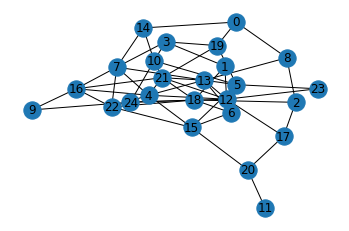

In [2]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
G = nx.gnm_random_graph(25, 55)
pos = nx.spring_layout(G,scale=0.8)
nx.draw_networkx(G,pos)
plt.axis('off')

### 1.1.2 The initial state

In these simulations, state is represented as a dictionary where the keys are node names and the values are the state of the node. We can specify the initial state either directly as one of these dictionaries, or we can specify a function that generates such a state dictionary.

The function version is cleaner; let's use it to generate a very simple initial state where every node has the same state: 'asleep'.

In [3]:
# An initial_state function takes one argument, the graph instance.

def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = 'asleep'
    return state

We can test this function out to make sure it works on our graph and produces a dictionary with a state value for each node:

In [4]:
initial_state(G)

{0: 'asleep',
 1: 'asleep',
 2: 'asleep',
 3: 'asleep',
 4: 'asleep',
 5: 'asleep',
 6: 'asleep',
 7: 'asleep',
 8: 'asleep',
 9: 'asleep',
 10: 'asleep',
 11: 'asleep',
 12: 'asleep',
 13: 'asleep',
 14: 'asleep',
 15: 'asleep',
 16: 'asleep',
 17: 'asleep',
 18: 'asleep',
 19: 'asleep',
 20: 'asleep',
 21: 'asleep',
 22: 'asleep',
 23: 'asleep',
 24: 'asleep'}

This looks good.

### 1.1.3 The state transition function

The crux of the simulation is the state transition function: this is where we specify the *dynamics*. This function takes two arguments, the graph and the current node states provided as a dictionary, and should return a dictionary of the updated states.

In this simple example, at each simulation step, each node with the `'asleep'` state will have a fixed probability to transition to the `'awake'` state. We'll specify this probability as `P_AWAKEN`, the probability an asleep node will awaken at each step.

Generically, in order to do a thing with some probability, we generate a random number between 0 and 1 with the `random.random()` function and compare to our probability threshold: if the random number is below our probability threshold, then we do the thing.

In [5]:
import random

P_AWAKEN = 0.2
def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        if current_state[node] == 'asleep':
            if random.random() < P_AWAKEN:
                next_state[node] = 'awake'
    return next_state

Note that this function only has to provide the states that *change* during this step, although no harm would be done by specifying the state for every node, changed or not.

We can do a dry run if we want, just to make sure our transition function works:

In [6]:
test_state = initial_state(G)
state_transition(G, test_state)

{1: 'awake', 7: 'awake', 20: 'awake', 22: 'awake'}

We should see some nodes transition to the `'awake'` state in this test run, which is good.

### 1.1.4 Putting together the pieces

We now have our three pieces: the graph, the initial state, and the state transition function. Let's put them together along with a name for our simulation to create a Simulation object:

The `name` provided here is optional, it just for us to keep track of the images we'll generate later.

This Simulation object has several useful methods. The first of these is the `.state()` method, which returns a dictionary for the current state of the simulation:

In [7]:
sim.state()

NameError: name 'sim' is not defined

We haven't done any steps in the simulation yet, so the state should be exactly our initial condition.

We can also draw the network with its nodes colored by their state values with the `.draw()` method:

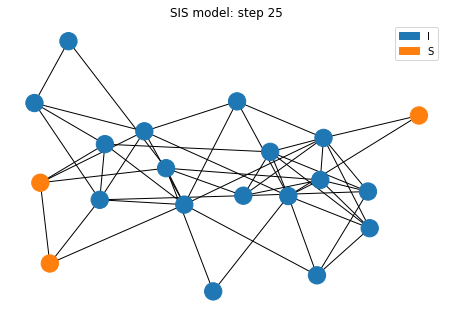

In [81]:
sim.draw()

Our initial condition has all nodes `'asleep'`, so this checks out.

## 1.2 Running the simulation

With our initial condition checked out, let's run the simulation! The simulation will advance in discrete *steps*: each step is one run of the state transition function.

The `.run()` method without any arguments will run the simulation one step:

In [17]:
sim.run()

We can confirm the simulation advanced a step by checking out the `.steps` property, which tells us how many times the state transition function has been run:

In [18]:
sim.steps

1

Let's see what our graph looks like after one step, noting that we can include keyword arguments for the `nx.draw()` function:

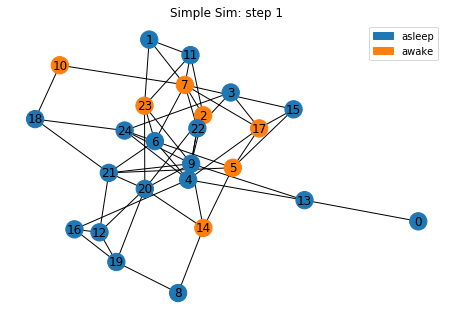

In [19]:
sim.draw(with_labels=True)

Some of the nodes are awake! We can also see this in the simulation state:

In [20]:
sim.state()

{0: 'asleep',
 1: 'asleep',
 2: 'awake',
 3: 'asleep',
 4: 'asleep',
 5: 'awake',
 6: 'asleep',
 7: 'awake',
 8: 'asleep',
 9: 'asleep',
 10: 'awake',
 11: 'asleep',
 12: 'asleep',
 13: 'asleep',
 14: 'awake',
 15: 'asleep',
 16: 'asleep',
 17: 'awake',
 18: 'asleep',
 19: 'asleep',
 20: 'asleep',
 21: 'asleep',
 22: 'asleep',
 23: 'awake',
 24: 'asleep'}

If we give the `.run()` method a number, we can run the simulation several steps at once:

In [21]:
sim.run(10)

In [22]:
sim.steps

11

The `.steps` method confirms that our simulation went through several simulation steps. Let's check up on the current state:

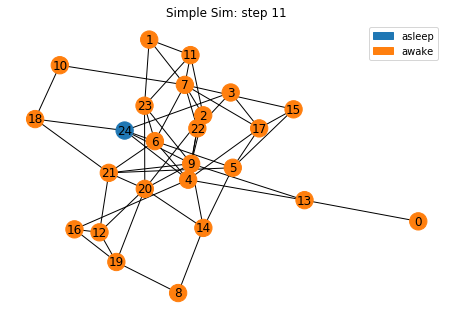

In [23]:
sim.draw(with_labels=True)

## 1.3 Visualizing the results

By this point, all or most of the nodes should be awake, but how did that transition occur? Was it gradual or all at once? With the `.plot()` method, we can plot the proportion of nodes in each state at each step of the simulation:

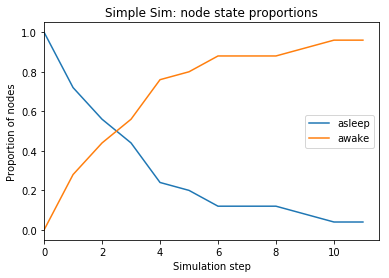

In [24]:
sim.plot()

If we want to visualize the state of the graph at a specific step, we can specify the desired step in the `.draw()` function.

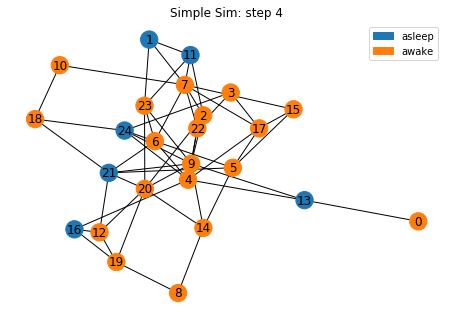

In [25]:
sim.draw(4, with_labels=True)

The same is true for the `.state()` method:

In [26]:
sim.state(4)

{0: 'awake',
 1: 'asleep',
 2: 'awake',
 3: 'awake',
 4: 'awake',
 5: 'awake',
 6: 'awake',
 7: 'awake',
 8: 'awake',
 9: 'awake',
 10: 'awake',
 11: 'asleep',
 12: 'awake',
 13: 'asleep',
 14: 'awake',
 15: 'awake',
 16: 'asleep',
 17: 'awake',
 18: 'awake',
 19: 'awake',
 20: 'awake',
 21: 'asleep',
 22: 'awake',
 23: 'awake',
 24: 'asleep'}

If we only want to plot a subset of the steps, we can do that too by passing the min and/or max steps we want to plot. Do note that the bounds passed to the `.plot()` method are half-open, like Python's `range()` function and list slices, so that `.plot(2, 8)` plots states from 2 and up to but *not* including 8.

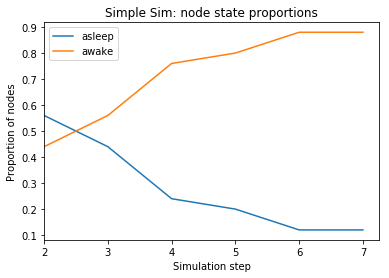

In [27]:
sim.plot(min_step=2, max_step=8)

# 2. The voter model

In our trivial awake/asleep model above we ignored the underlying graph structure and each node's dynamics was independent of its neighbors. In interesting network models, we make use of the graph connectivity in some way.

The voter model is a simple model of network opinion dynamics capable of producing interesting output. This model is described in detail in the textbook; we're going to implement it here.

## 2.1 Create the simulation

### 2.1.1 The Graph

We're going to use another random graph here, same as before.

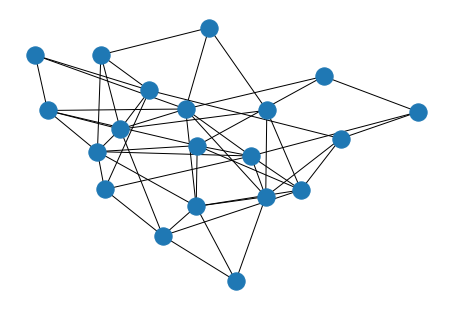

In [28]:
%matplotlib inline
import networkx as nx

G = nx.gnm_random_graph(20, 50)
nx.draw(G)

### 2.1.2 Initial state

For the initial state, we will randomly assign each node a state by randomly selecting a letter A to D -- we're not limited to two states here!

We'll make use of `random.choice()` in both the initial state and state transition functions. This function is used to randomly choose one item from a given collection.

In [29]:
import random
import string

def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = random.choice('ABCD')
    return state

Let's make sure this works:

In [30]:
initial_state(G)

{0: 'D',
 1: 'C',
 2: 'B',
 3: 'D',
 4: 'B',
 5: 'C',
 6: 'D',
 7: 'C',
 8: 'D',
 9: 'D',
 10: 'C',
 11: 'C',
 12: 'D',
 13: 'A',
 14: 'D',
 15: 'D',
 16: 'D',
 17: 'B',
 18: 'B',
 19: 'C'}

### 2.1.3 State transition

The algorithm at the heart of the voter model works like this: for each node in the graph, choose a neighbor at random and copy their "opinion", *i.e.* set this node's state to the same value as that of the neighbor.

* For each node in the graph
  * Choose a neighbor at random
  * Set this node state equal to the neighbor state 

In [31]:
def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        # Caveat: what if the node has no neighbors?
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            next_state[node] = current_state[neighbor]
    return next_state

Let's test this out before moving forward:

In [32]:
test_state = initial_state(G)
state_transition(G, test_state)

{0: 'A',
 1: 'D',
 2: 'D',
 3: 'C',
 4: 'D',
 5: 'A',
 6: 'B',
 7: 'C',
 8: 'B',
 9: 'D',
 10: 'D',
 11: 'D',
 12: 'D',
 13: 'A',
 14: 'D',
 15: 'C',
 16: 'B',
 17: 'C',
 18: 'D',
 19: 'A'}

###  2.1.4 The Simulation instance

Looks good. Now let's create the simulation and visualize the initial state:

In [33]:
import matplotlib.pyplot as plt

sim = Simulation(G, initial_state, state_transition, name='Voter Model')

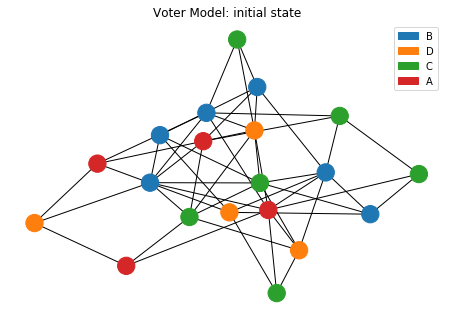

In [34]:
sim.draw()

# if you care about the order of the labels in the legend,
# you can specify labels='ABCD' as a keyword argument for .draw()

## 2.2 Run the simulation

Let's run this simulation several steps and see where we end up:

In [35]:
sim.run(40)

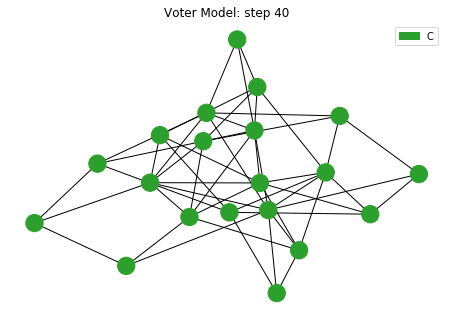

In [36]:
sim.draw()

## 2.3 Visualize the results

It's probably different from where we started; let's see how we got here:

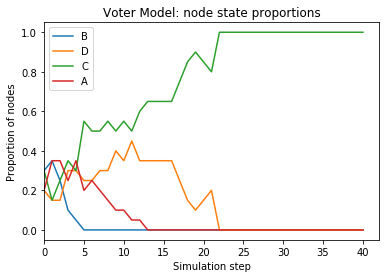

In [37]:
sim.plot()

Go ahead and execute the previous few cells again, running the simulation forward and examining the state, until it reaches the long-term steady state: all of the nodes should eventually end up with the same state.

## 2.4 Synchronous vs. asynchronous updates

As written, this `state_transition` function performs a **synchronous** update, *i.e.* all of the nodes' states are updated at the same time, after the function returns the new state:

In [38]:
# This is the same as in 2.1.3
import random

def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            next_state[node] = current_state[neighbor]
    return next_state

Note how this function never changes the values of `current_state` so that each node's update is based on the same information. Since each node "sees" the same state, the order in which we update the nodes doesn't matter. This is equivalent to updating all of the node states simultaneously. 

One can instead perform an **asynchronous** update, where each node sees the state changes that have taken place this step, by making in-place changes to `current_state`:

In [39]:
# This example is potentially biased, don't use it
def state_transition_async(G, current_state):
    for node in G.nodes:
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            current_state[node] = current_state[neighbor]
    return current_state

In this example, each node's view of `current_state` reflects the changes made in this step by previous node updates.

There is a potential problem here, however: `G.nodes` is likely to always return the nodes in the same order, thus performing the updates in the same order and potentially introducing bias. We should instead loop over the nodes in a random order each time:

In [40]:
def state_transition_async(G, current_state):
    # Randomizing the update order prevents bias
    nodes_to_update = list(G.nodes)
    random.shuffle(nodes_to_update)
    for node in nodes_to_update:
        if G.degree(node) > 0:
            neighbor = random.choice(list(G.neighbors(node)))
            current_state[node] = current_state[neighbor]
    return current_state

We can make use of this new state transition function by passing it to the `Simulation` class, then run it and compare to the synchronous version above.

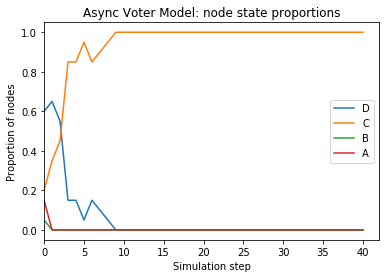

In [41]:
sim = Simulation(G, initial_state, state_transition_async, name='Async Voter Model')
sim.run(40)
sim.plot()

Asynchronous updates may or may not produce a different result depending on the particular dynamics of your simulation. Synchronous updates are slightly simpler in terms of their assumptions which is an advantage, but certain update mechanisms can fail to converge to the steady state without asynchronous updates.

## 2.5 Stop condition

In some situations we may want to specify a condition which, when true, causes the simulation to end early. In this Voter model example, we observe that the system state can't change once all of the nodes have the same state. In order to avoid running the simulation longer than necessary, we can specify a stop condition to stop the simulation if all nodes have the same state.

This function takes the graph and current state as arguments, same as the state transition function, and returns `True` if the model should stop.

In [42]:
def stop_condition(G, current_state):
    unique_state_values = set(current_state.values())
    is_stopped = len(unique_state_values) <= 1
    return is_stopped

Let's create another instance of the voter model, specifying a stop condition, and run it for more steps than we think we'll need. We still need to specify a maximum number of steps in case there is a bug in our stop condition and it never returns True.

In [43]:
sim = Simulation(G, initial_state, state_transition, stop_condition, name='Voter model')
sim.run(100)

Stop condition met at step 10.


In [44]:
sim.steps

10

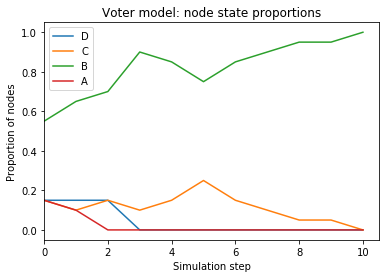

In [45]:
sim.plot()

## 2.6 Rewiring the graph

Since we have access to the Graph instance in our transition function, we can add or remove links in the graph if our system calls for it. Let's add an extension to the voter model such that a node may also "unfriend" another node by removing the edge between them if their state differs.

In [46]:
def state_transition_async_rewiring(G, current_state):
    # Randomizing the update order prevents bias
    nodes_to_update = list(G.nodes)
    random.shuffle(nodes_to_update)
    for node in nodes_to_update:
        if G.degree(node) > 0:
            # This is the same as before
            neighbor = random.choice(list(G.neighbors(node)))
            current_state[node] = current_state[neighbor]
            # This is the new part
            neighbor = random.choice(list(G.neighbors(node)))
            if current_state[node] != current_state[neighbor]:
                G.remove_edge(node, neighbor)
            
    return current_state

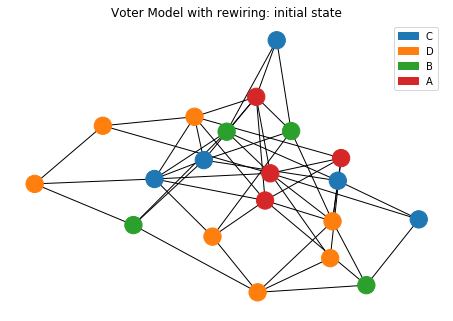

In [47]:
sim = Simulation(G, initial_state, state_transition_async_rewiring, stop_condition,
                 name='Voter Model with rewiring')
sim.draw()

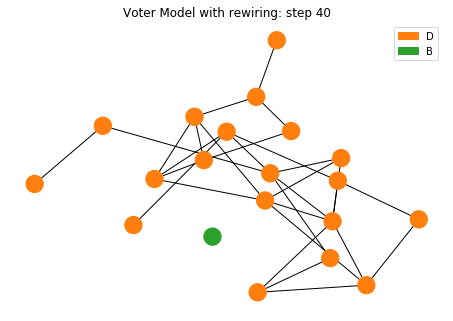

In [48]:
sim.run(40)
sim.draw()

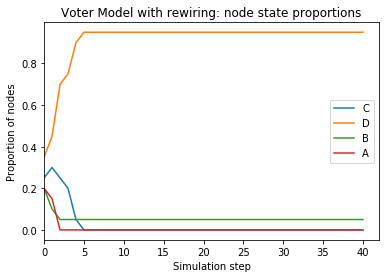

In [49]:
sim.plot()

The long-term behavior of this modified simulation is different than the previous model: it often ends up in a configuration with disconnected components, each containg nodes all of the same state. As such, the stop conditon as written doesn't trigger. Creating a proper `stop_condition` function for this state transition function is left as an exercise to the reader.

# 3. The SIS model

This is one of the fundamental models of spreading dynamics on networks, examined in detail in the text. We will implement this spreading model using our simulation framework.

## 3.1 Create the Simulation

### 3.1.1 The Graph

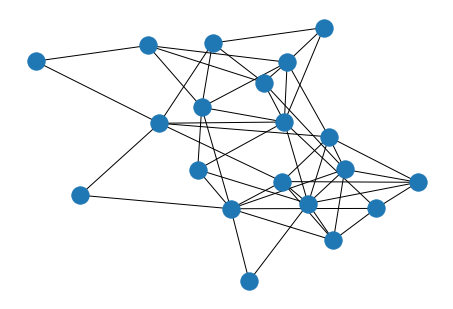

In [50]:
%matplotlib inline
import networkx as nx

G = nx.gnm_random_graph(20, 50)
nx.draw(G)

### 3.1.2 Initial state

We will initially assign every node to the 'S' state and then randomly choose one node to infect by setting it to the 'I' state. You should experiment with different choices of the "patient zero" node to infect and see how it affects the spreading dynamics, *e.g.* by selecting a high- or low-degree node.

In [51]:
import random

def initial_state(G):
    state = {}
    for node in G.nodes:
        state[node] = 'S'
    
    patient_zero = random.choice(list(G.nodes))
    state[patient_zero] = 'I'
    return state

Let's make sure this works:

In [52]:
initial_state(G)

{0: 'S',
 1: 'S',
 2: 'S',
 3: 'S',
 4: 'S',
 5: 'S',
 6: 'S',
 7: 'S',
 8: 'S',
 9: 'S',
 10: 'S',
 11: 'S',
 12: 'S',
 13: 'S',
 14: 'I',
 15: 'S',
 16: 'S',
 17: 'S',
 18: 'S',
 19: 'S'}

### 3.1.3 State transition

The SIS model involves two parameters, $\beta$ is the probability to transition from S to I given an infected neighbor, and $\mu$, the probability of transitioning from I to S.

In pseudocode, the algorithm looks like this:

* For each node in the graph
  * If node has state I
    * The node transitions to state S with probability $\mu$
  * Else node has state S
    * For each neighbor of the node
      * If neighbor has state I
        * The node transitions to state I with probability $\beta$

The logic gets a little deep with the indentations, but the code looks very much like this pseudocode.

In [53]:
MU = 0.1
BETA = 0.1

def state_transition(G, current_state):
    next_state = {}
    for node in G.nodes:
        if current_state[node] == 'I':
            if random.random() < MU:
                next_state[node] = 'S'
        else: # current_state[node] == 'S'
            for neighbor in G.neighbors(node):
                if current_state[neighbor] == 'I':
                    if random.random() < BETA:
                        next_state[node] = 'I'

    return next_state

Let's test this out before moving forward:

In [54]:
test_state = initial_state(G)
state_transition(G, test_state)

{}

It's possible, depending on your parameter values, that the first transition results in no state changes. This is okay, even expected. It might take a few tries before any states are updated and a nonempty dict is produced. It's also okay to skip this, as we're just checking our code accuracy, but it is easier to debug here than in the simulation proper.

### 3.1.4 Simulation

Now let's create the simulation and visualize the initial state:

In [55]:
sim = Simulation(G, initial_state, state_transition, name='SIS model')

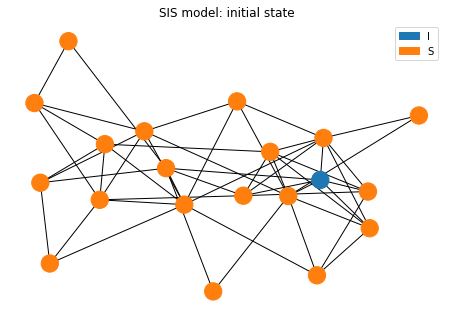

In [56]:
sim.draw()

## 3.2 Run the simulation

Let's run this simulation several steps and see where we end up:

In [57]:
sim.run(25)

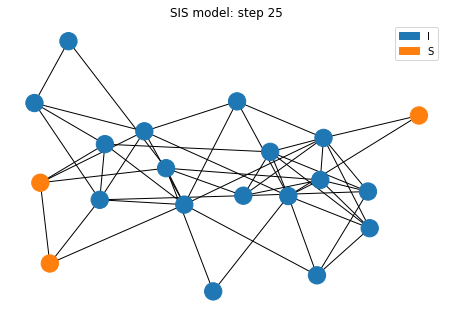

In [58]:
sim.draw()

It's probably different from where we started; let's see how we got here:

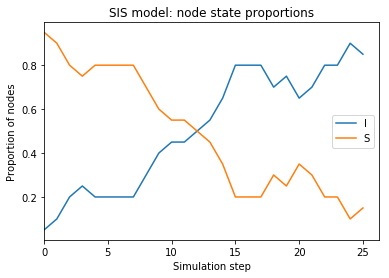

In [59]:
sim.plot()

Go ahead and execute the previous few cells again, running the simulation forward and examining the state, until it reaches the long-term steady state: eventually the proportion curves will flatten out as the proportion of each node state will fluctuate around some average value.

Now go back, adjust the `BETA` and `MU` parameter values, and see how the steady state changes!

# 4. Conclusion

In each of the "real" models, the voter and SIS models, we executed many of the steps in exactly the same way. This is to clearly illustrate which parts differ between different simulations and which parts remain the same. You can and should definitely experiment with altering these models or writing your own; for example, the threshold model is a straightforward extension of the voter model, and the SIR model is an extension of the SIS model.

Another avenue of exploration is to compare how simulations with the same parameters produce different results given different graphs. 